In [1]:
import psi4
import numpy as np
import matplotlib.pyplot as plt

In [2]:
psi4.core.set_output_file('output.dat', False)
psi4.set_memory('500 MB')

molecule = psi4.geometry("""
0 1
O
H 1 0.96
H 1 0.96 2 104.5
""")

psi4.set_options({
    'basis': '6-31g',
    'scf_type': 'df',
    'e_convergence': 1e-8,
    'd_convergence': 1e-8
})

opt_energy, opt_wfn, history = psi4.optimize('scf', return_wfn=True, return_history=True)


Optimizer: Optimization complete!


In [3]:
e, wfn = psi4.frequencies(
    "scf", ref_gradient=opt_wfn.gradient(), molecule=opt_wfn.molecule(), return_wfn=True
)

In [4]:
hessian, _ = psi4.hessian(
    "scf",
    ref_gradient=opt_wfn.gradient(),
    return_wfn= True
)

vibinfo, vibtext = psi4.driver.qcdb.vib.harmonic_analysis(
    hessian.np,
    wfn.molecule().geometry().np,
    np.array(
        [wfn.molecule().mass(i) for i in range(len(wfn.molecule().geometry().np))]
    ),
    wfn.basisset(),
    wfn.molecule().irrep_labels(),
    wfn.variable("SCF DIPOLE GRADIENT").np.T,
    True,
    True,
)

In [7]:
vibinfo

{'q': Datum(numeric=True, label='normal mode', units='a0 u^1/2', data=array([[ 0.00000000, -0.00000000, -0.00000000,  1.00000000, -0.00000000,
         -0.00000000,  0.00000000, -0.00000000,  0.00000000],
        [ 0.67590382, -0.26880150, -0.00000000, -0.00000000,  0.54309561,
          0.31085578, -0.00000000,  0.00000000, -0.28163029],
        [-0.53078632,  0.28103234,  0.00000000,  0.00000000,  0.70852701,
          0.15925234, -0.28608608,  0.17340596,  0.00000000],
        [ 0.42693431,  0.88789338, -0.00000000,  0.00000000,  0.00615337,
         -0.17127341,  0.00000000, -0.00000000, -0.00000000],
        [ 0.08994406,  0.03752458, -0.00000000, -0.00000000, -0.04128667,
          0.41725084,  0.36652627,  0.60469703,  0.56098050],
        [-0.25041850,  0.22488568,  0.00000000,  0.00000000, -0.08322984,
          0.53861319,  0.56985601, -0.34540801, -0.38163212],
        [ 0.00000000,  0.00000000,  1.00000000,  0.00000000,  0.00000000,
          0.00000000, -0.00000000,  0.000

Text(0, 0.5, 'Intensity')

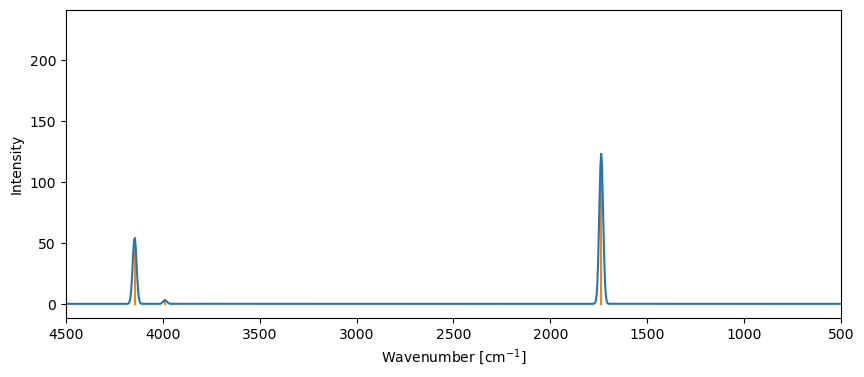

In [8]:
def gaussian(x, height, mu, sigma):
    return height * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
sigma = 10
x = np.linspace(500, 4500, 1000)
y = np.zeros_like(x)
for height, mu in zip(np.real(vibinfo["IR_intensity"].data), np.real(vibinfo["omega"].data)):
    y += gaussian(x, height, mu, sigma)
    ax.plot([mu, mu], [0, height], color="tab:orange")
ax.plot(x, y)

ax.set_xlim(4500, 500)
ax.set_xlabel(r"Wavenumber [$\mathrm{cm}^{-1}$]")
ax.set_ylabel(r"Intensity")